In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

In [2]:
import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [3]:
batch_size = 100
n_dim = 2

In [4]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 512),
        nn.ReLU(),
        nn.Linear(512, dims_out)
    )

In [6]:
inn = Ff.SequenceINN(n_dim)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

In [7]:
optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

In [41]:
import tqdm

for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    data, label = make_moons(n_samples=batch_size, noise=0.05)
    x = torch.Tensor(data)
    z, log_jac_det = inn(x)
    loss = 0.5 * torch.sum(z ** 2, dim=1) - log_jac_det
    loss = loss.mean() / n_dim
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


In [42]:
z = torch.randn(batch_size*1000, n_dim)
samples, _ = inn(z, rev=True)

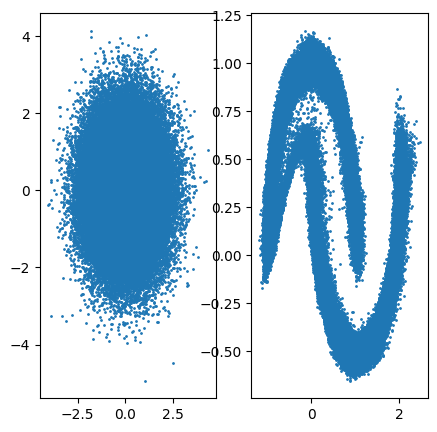

In [43]:
import matplotlib.pyplot as plt
samples = samples.detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].scatter(z[:, 0], z[:, 1], s=1)
ax[1].scatter(samples[:, 0], samples[:, 1], s=1)

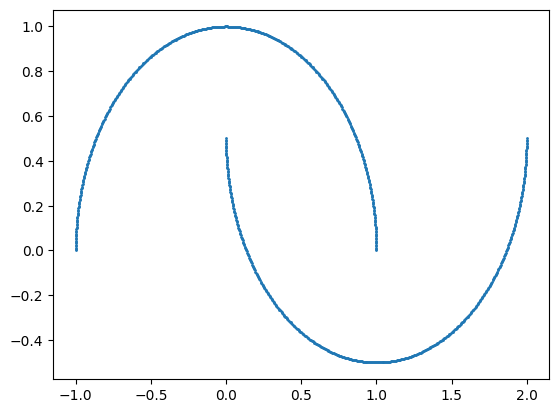

In [44]:
moons = make_moons(n_samples=1000)
plt.scatter(moons[0][:, 0], moons[0][:, 1], s=1)

In [67]:
dataset_dir = 'C:\\Users\had-int22\PycharmProjects\Pytorch_AD\data\jelly'
import os
import pathlib
import random
import torch
import torch.utils.data
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [82]:
class JellyDataset(torch.utils.data.Dataset):
    """
    JellyDatasetをロードするためのクラス
    """
    def __init__(self, root: str, category: str, input_size: int, is_train: bool = True, test_ratio: float=0.2, is_mask: bool=False, seed: int=42):
        """
        Args:
            root: JellyDatasetのルートディレクトリ．このディレクトリ直下に各クラスのデータディレクトリを含む．
            category: クラス名. Ex. 'hair1'
            input_size: 事前学習済みモデルの入力画像の形．256と指定された場合は(256, 256)の画像を表す．
            is_train: 訓練データかどうか
            test_ratio: 全体のデータのうち，何割を評価用に使うか
            is_mask: 異常箇所のマスクがあるかどうか．
            seed: 正常画像から訓練に使うものと評価に使うものを分割する際のランダムシード

        Attributes:
            self.image_transform: 画像に対するpreprocessing
            self.image_files: 画像のファイルパスのリスト
            self.label: 評価データにおける異常(1),正常(0)のラベル
            self.target_transform: 正解マスク画像に対するpreprcessing
        """

        # 事前学習済みモデルに入力するための画像変換を定義
        # ImageNetによる事前学習を想定しているため，ImageNet用の正規化をする．詳細は[https://teratail.com/questions/295871]を参照
        self.image_transform = transforms.Compose(
            [
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

        # 正常・異常データのパスのリスト取得
        random.seed(seed)
        normal_dir = pathlib.Path(os.path.join(root, category, 'OK_Clip'))
        anormal_dir = pathlib.Path(os.path.join(root, category, 'NG_Clip'))
        normal_list = list(normal_dir.glob('*.jpg'))
        anormal_list = list(anormal_dir.glob('*.jpg'))

        # 正常画像をシャッフルし，test_ratioで指定された数の正常画像以外を訓練データとして利用
        random.shuffle(normal_list)

        if is_train:
            self.image_files = normal_list[int(len(normal_list) * test_ratio):]
        else:
            # 正常画像の一部を評価用のデータとして利用
            self.image_files = normal_list[:int(len(normal_list) * test_ratio)]
            # ラベルを作成
            self.label = [0] * len(self.image_files)

            # 異常画像を評価用のデータとして利用
            self.image_files += anormal_list
            self.label += [1] * len(anormal_list)

            # 異常マスクがある場合には，マスクに対する変換も定義
            if is_mask:
                self.target_transform = transforms.Compose(
                    [
                        transforms.Resize(input_size),
                        transforms.ToTensor(),
                    ]
                )
        self.is_train = is_train

    def __getitem__(self, index):
        """
        データセットからindexで指定されたデータを取得する．dataset[idx]のようにリストから値を取得するように扱える．
        Args:
            index: データのindex

        Returns:
            output:
                if self.is_train: 事前学習済みモデルへの入力画像
                else: 事前学習済み画像への入力画像とtarget画像(異常箇所の正解マスク画像), マスクがない場合はラベル(0, 1)
        """
        # 指定されたindexの画像を読み込み，事前学習済みモデルに対応する形式に変換
        # -> (C, input_size, input_size)
        image_file = self.image_files[index]
        image = Image.open(image_file)
        image = self.image_transform(image)

        if self.is_train:
            return image

        else:
            label = self.label[index]
            return image, label

    def __len__(self):
        """"
        データセットの長さを返す．len(dataset)のようにして取得可能．
        Returns: データセット内のデータ数
        """
        return len(self.image_files)

In [56]:
import random
random.seed(42)

image_files = pathlib.Path(os.path.join(dataset_dir, 'glove1')).glob("OK_Clip/*.jpg")
l = list(image_files)
random.shuffle(l)
random.shuffle(l)
l

[WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_70.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_84.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_54.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_6.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_13.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_81.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_38.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_86.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_53.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/jelly/glove1/OK_Clip/OK_100.jpg'),
 WindowsPa

In [99]:
from sklearn.metrics import roc_auc_score
pred = [-0.1, -0.9, -0.8, -0.2, -0.9]
true = [1, 0, 0, 1, 0]
roc_auc_score(true, pred)

1.0

In [5]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

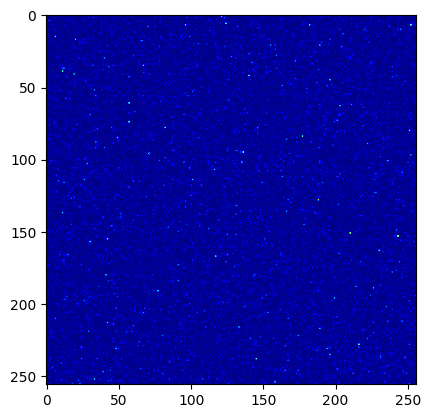

In [14]:
x = 1 * torch.exp(torch.randn(1, 256, 256))
plt.imshow(x.transpose(0, 2), cmap='jet')

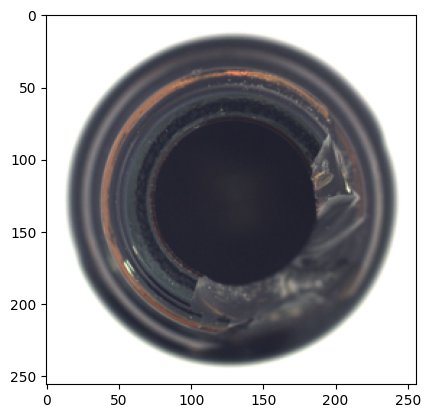

In [10]:
img = Image.open("C:\\Users\had-int22\PycharmProjects\Pytorch_AD\data\mvtec\\bottle\\test\\broken_large\\000.png")
img = np.array(img.resize((256, 256)))
plt.imshow(img)

In [11]:
img = torch.from_numpy(img)
img.shape

torch.Size([256, 256, 3])

In [15]:
img_ = torch.permute(img, [2, 0, 1])
img_.shape

torch.Size([3, 256, 256])

In [16]:
img_T = img_.transpose(0, 2)
img_n = img_T.cpu().numpy()

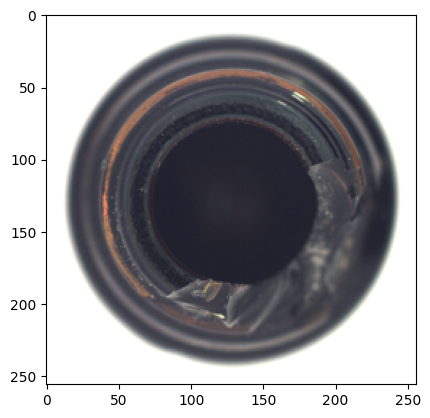

In [17]:
plt.imshow(img_n)